### What does the data look like?

Show the first 10 rows of the dataset.

In [1]:
import duckdb
import pandas as pd

file_path = 'data/encampments.csv'
conn = duckdb.connect()

# Get the first 10 rows of the CSV file
result = conn.execute(f"SELECT * FROM read_csv('{file_path}') LIMIT 10")

# Print the result -- do not wrap columns
pd.set_option('display.expand_frame_repr', False)
print(result.fetchdf())

  Service Request Number        Created Date         Method Received  Status                                  Location       X_Value        Y_Value   Latitude   Longitude                 Latitude/Longitude  ZIP Code  Council District Police Precinct         Neighborhood Are there people present? Are there tents, structures, or tarps? Are there RVs/cars/misc. vehicles?         Is the encampment blocking access?                          Is there trash or debris?
0            22-00156375 2022-06-28 08:54:24     Find It Fix It Apps  Closed       5657 26TH AVE SW, SEATTLE, WA 98106  1.261980e+06  204495.480701  47.550284 -122.365869  POINT (-122.36586867 47.55028426)     98106                 1       SOUTHWEST           HIGH POINT                       Yes                                    Yes                                Yes   Recreation amenity,Entrance to residence  Garbage/Loose litter,Needles/Sharps,Hazardous ...
1            22-00156446 2022-06-28 09:32:47  Citizen Web Intake App  

### How much data and over what date range?

In [2]:
# Count the number of rows in the dataset
result = conn.execute(f"SELECT COUNT(*) FROM read_csv('{file_path}')")
print(result.fetchdf())

   count_star()
0        108594


In [3]:
# Run a query to return the oldest and most recent "Created Date"
result = conn.execute(f"SELECT MIN(\"Created Date\"), MAX(\"Created Date\") FROM read_csv('{file_path}')")
print(result.fetchdf())

  min("Created Date") max("Created Date")
0 2022-06-27 17:23:12 2024-12-16 23:55:16


### All time top-15 most common report locations

In [4]:
# Return the top 15 most common "Location" values. Grab the Location and the "Latitude/Longitude" columns
result = conn.execute(f"SELECT Location, Latitude, Longitude, COUNT(*) as TheCount FROM read_csv('{file_path}') GROUP BY Location, Latitude, Longitude ORDER BY COUNT(*) DESC LIMIT 15")
print(result.fetchdf())

                                     Location   Latitude   Longitude  TheCount
0            105 N 87TH ST, SEATTLE, WA 98103  47.692265 -122.357696       715
1   12363 LAKE CITY WAY NE, SEATTLE, WA 98125  47.719107 -122.295884       696
2       515 BOYLSTON AVE E, SEATTLE, WA 98102  47.623889 -122.323335       572
3       1201 UNIVERSITY ST, SEATTLE, WA 98101  47.611950 -122.325495       541
4               400 ROY ST, SEATTLE, WA 98109  47.625602 -122.348652       359
5        500 FEDERAL AVE E, SEATTLE, WA 98102  47.623288 -122.318614       357
6          8501 1ST AVE NW, SEATTLE, WA 98117  47.690845 -122.358324       312
7        6800 WEEDIN PL NE, SEATTLE, WA 98115  47.678569 -122.321618       296
8     509 QUEEN ANNE AVE N, SEATTLE, WA 98109  47.623532 -122.357098       294
9          700 NW 100TH PL, SEATTLE, WA 98177  47.701711 -122.365042       281
10               27 ROY ST, SEATTLE, WA 98109  47.625284 -122.355662       275
11     1500 FAIRVIEW AVE E, SEATTLE, WA 98102  47.63

In [5]:
import ipyleaflet
import typing as t

result = conn.execute(f"SELECT Location, Latitude, Longitude, COUNT(*) as TheCount FROM read_csv('{file_path}') GROUP BY Location, Latitude, Longitude ORDER BY COUNT(*) DESC LIMIT 15")

# Create a map, centered in Seattle
m = ipyleaflet.Map(center=(47.6062, -122.3321), zoom=10)

# Make a marker for each encampment. The columns are named "Location", "Latitude", and "Longitude". Use the names.
for row in result.fetchdf().itertuples():
	the_count = t.cast(int, row.TheCount)
	marker = ipyleaflet.CircleMarker(location=(row.Latitude, row.Longitude), title=row.Location, radius=int((the_count/715.0) * 50))
	m.add_layer(marker)

# Display the map -- make it big!
m.layout.height = '1200px'
m


Map(center=[47.6062, -122.3321], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', '…

### Calendar year 2024 top-15 most common report locations

In [6]:
# Do the top-15 list above, but only for incidents in 2024
# Remember that "Created Date" is a TIMESTAMP
result = conn.execute(f"SELECT Location, Latitude, Longitude, COUNT(*) as TheCount FROM read_csv('{file_path}') WHERE \"Created Date\" >= '2024-01-01' AND \"Created Date\" < '2025-01-01' GROUP BY Location, Latitude, Longitude ORDER BY COUNT(*) DESC LIMIT 15")
print(result.fetchdf())

                                     Location   Latitude   Longitude  TheCount
0   12363 LAKE CITY WAY NE, SEATTLE, WA 98125  47.719107 -122.295884       454
1       1201 UNIVERSITY ST, SEATTLE, WA 98101  47.611950 -122.325495       432
2     509 QUEEN ANNE AVE N, SEATTLE, WA 98109  47.623532 -122.357098       292
3       515 BOYLSTON AVE E, SEATTLE, WA 98102  47.623889 -122.323335       288
4         5315 15TH AVE NW, SEATTLE, WA 98107  47.667751 -122.376824       251
5          700 NW 100TH PL, SEATTLE, WA 98177  47.701711 -122.365042       232
6        6800 WEEDIN PL NE, SEATTLE, WA 98115  47.678569 -122.321618       226
7          1106 SUMMIT AVE, SEATTLE, WA 98101  47.611185 -122.323488       210
8         901 NW MARKET ST, SEATTLE, WA 98107  47.668386 -122.368876       203
9               400 ROY ST, SEATTLE, WA 98109  47.625602 -122.348652       173
10        8342 MARY AVE NW, SEATTLE, WA 98117  47.689945 -122.375292       153
11       500 FEDERAL AVE E, SEATTLE, WA 98102  47.62

In [7]:
# Map the 2024 incidents list
result = conn.execute(f"SELECT Location, Latitude, Longitude, COUNT(*) as TheCount FROM read_csv('{file_path}') WHERE \"Created Date\" >= '2024-01-01' AND \"Created Date\" < '2025-01-01' GROUP BY Location, Latitude, Longitude ORDER BY COUNT(*) DESC LIMIT 15")

m = ipyleaflet.Map(center=(47.6062, -122.3321), zoom=10)
for row in result.fetchdf().itertuples():
	the_count = t.cast(int, row.TheCount)
	marker = ipyleaflet.CircleMarker(location=(row.Latitude, row.Longitude), title=row.Location, radius=int((the_count/454.0) * 50))
	m.add_layer(marker)

m.layout.height = '1200px'
m

Map(center=[47.6062, -122.3321], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', '…

### Last 3 months top-15 most common report locations

In [8]:
# Now do last 3 months (90 days ending December 16, 2024)
result = conn.execute(f"SELECT Location, Latitude, Longitude, COUNT(*) as TheCount FROM read_csv('{file_path}') WHERE \"Created Date\" >= '2024-09-17' AND \"Created Date\" < '2024-12-16' GROUP BY Location, Latitude, Longitude ORDER BY COUNT(*) DESC LIMIT 15")
print(result.fetchdf())

                                     Location   Latitude   Longitude  TheCount
0       1201 UNIVERSITY ST, SEATTLE, WA 98101  47.611950 -122.325495       269
1     509 QUEEN ANNE AVE N, SEATTLE, WA 98109  47.623532 -122.357098       222
2   12363 LAKE CITY WAY NE, SEATTLE, WA 98125  47.719107 -122.295884       198
3       515 BOYLSTON AVE E, SEATTLE, WA 98102  47.623889 -122.323335        96
4         901 NW MARKET ST, SEATTLE, WA 98107  47.668386 -122.368876        92
5          2012 NW 56TH ST, SEATTLE, WA 98107  47.669625 -122.383255        74
6          1106 SUMMIT AVE, SEATTLE, WA 98101  47.611185 -122.323488        74
7         2302 WESTERN AVE, SEATTLE, WA 98121  47.612847 -122.347450        63
8         8342 MARY AVE NW, SEATTLE, WA 98117  47.689945 -122.375292        57
9          8415 8TH AVE NW, SEATTLE, WA 98117  47.690403 -122.366276        56
10        1506 E SPRING ST, SEATTLE, WA 98122  47.611730 -122.312402        52
11      19 W REPUBLICAN ST, SEATTLE, WA 98119  47.62

In [9]:
# Map the last 3 months
result = conn.execute(f"SELECT Location, Latitude, Longitude, COUNT(*) as TheCount FROM read_csv('{file_path}') WHERE \"Created Date\" >= '2024-09-17' AND \"Created Date\" < '2024-12-16' GROUP BY Location, Latitude, Longitude ORDER BY COUNT(*) DESC LIMIT 15")

m = ipyleaflet.Map(center=(47.6062, -122.3321), zoom=10)
for row in result.fetchdf().itertuples():
	the_count = t.cast(int, row.TheCount)
	marker = ipyleaflet.CircleMarker(location=(row.Latitude, row.Longitude), title=row.Location, radius=int((the_count/269.0) * 50))
	m.add_layer(marker)

m.layout.height = '1200px'
m

Map(center=[47.6062, -122.3321], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', '…

### Last month top-15 most common report locations

In [10]:
# And last month (30 days ending December 16, 2024)
result = conn.execute(f"SELECT Location, Latitude, Longitude, COUNT(*) as TheCount FROM read_csv('{file_path}') WHERE \"Created Date\" >= '2024-11-16' AND \"Created Date\" < '2024-12-16' GROUP BY Location, Latitude, Longitude ORDER BY COUNT(*) DESC LIMIT 15")
print(result.fetchdf())

                                     Location   Latitude   Longitude  TheCount
0     509 QUEEN ANNE AVE N, SEATTLE, WA 98109  47.623532 -122.357098        55
1           100 YESLER WAY, SEATTLE, WA 98104  47.601983 -122.333764        32
2        1144 NW LEARY WAY, SEATTLE, WA 98107  47.663431 -122.372827        28
3            130 1ST AVE W, SEATTLE, WA 98119  47.619594 -122.357654        25
4       1201 UNIVERSITY ST, SEATTLE, WA 98101  47.611950 -122.325495        21
5       515 BOYLSTON AVE E, SEATTLE, WA 98102  47.623889 -122.323335        20
6     1935 N NORTHGATE WAY, SEATTLE, WA 98133  47.708325 -122.334407        20
7          1106 SUMMIT AVE, SEATTLE, WA 98101  47.611185 -122.323488        19
8     4501 BROOKLYN AVE NE, SEATTLE, WA 98105  47.661506 -122.314572        18
9   2358 CALIFORNIA AVE SW, SEATTLE, WA 98116  47.581379 -122.386233        17
10      19 W REPUBLICAN ST, SEATTLE, WA 98119  47.623103 -122.357648        16
11           1811 18TH AVE, SEATTLE, WA 98122  47.61

In [11]:
# Map the last month
result = conn.execute(f"SELECT Location, Latitude, Longitude, COUNT(*) as TheCount FROM read_csv('{file_path}') WHERE \"Created Date\" >= '2024-11-16' AND \"Created Date\" < '2024-12-16' GROUP BY Location, Latitude, Longitude ORDER BY COUNT(*) DESC LIMIT 15")

m = ipyleaflet.Map(center=(47.6062, -122.3321), zoom=10)
for row in result.fetchdf().itertuples():
	the_count = t.cast(int, row.TheCount)
	marker = ipyleaflet.CircleMarker(location=(row.Latitude, row.Longitude), title=row.Location, radius=int((the_count/55.0) * 50))
	m.add_layer(marker)

m.layout.height = '1200px'
m

Map(center=[47.6062, -122.3321], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', '…

### Change in reports over time

In [28]:
# Start by counting the number of unique locations in the dataset:
result = conn.execute(f"SELECT COUNT(DISTINCT Location) FROM read_csv('{file_path}')")
df = result.fetchdf()

total_rows: float = 108_594
unique_locations: float = t.cast(float, df.iloc[0, 0])
avg_reports_per_location = total_rows / unique_locations
print(f"Total rows: {total_rows}, unique locations: {unique_locations}, average reports per location: {avg_reports_per_location}")

Total rows: 108594, unique locations: 21378, average reports per location: 5.0797081111422955


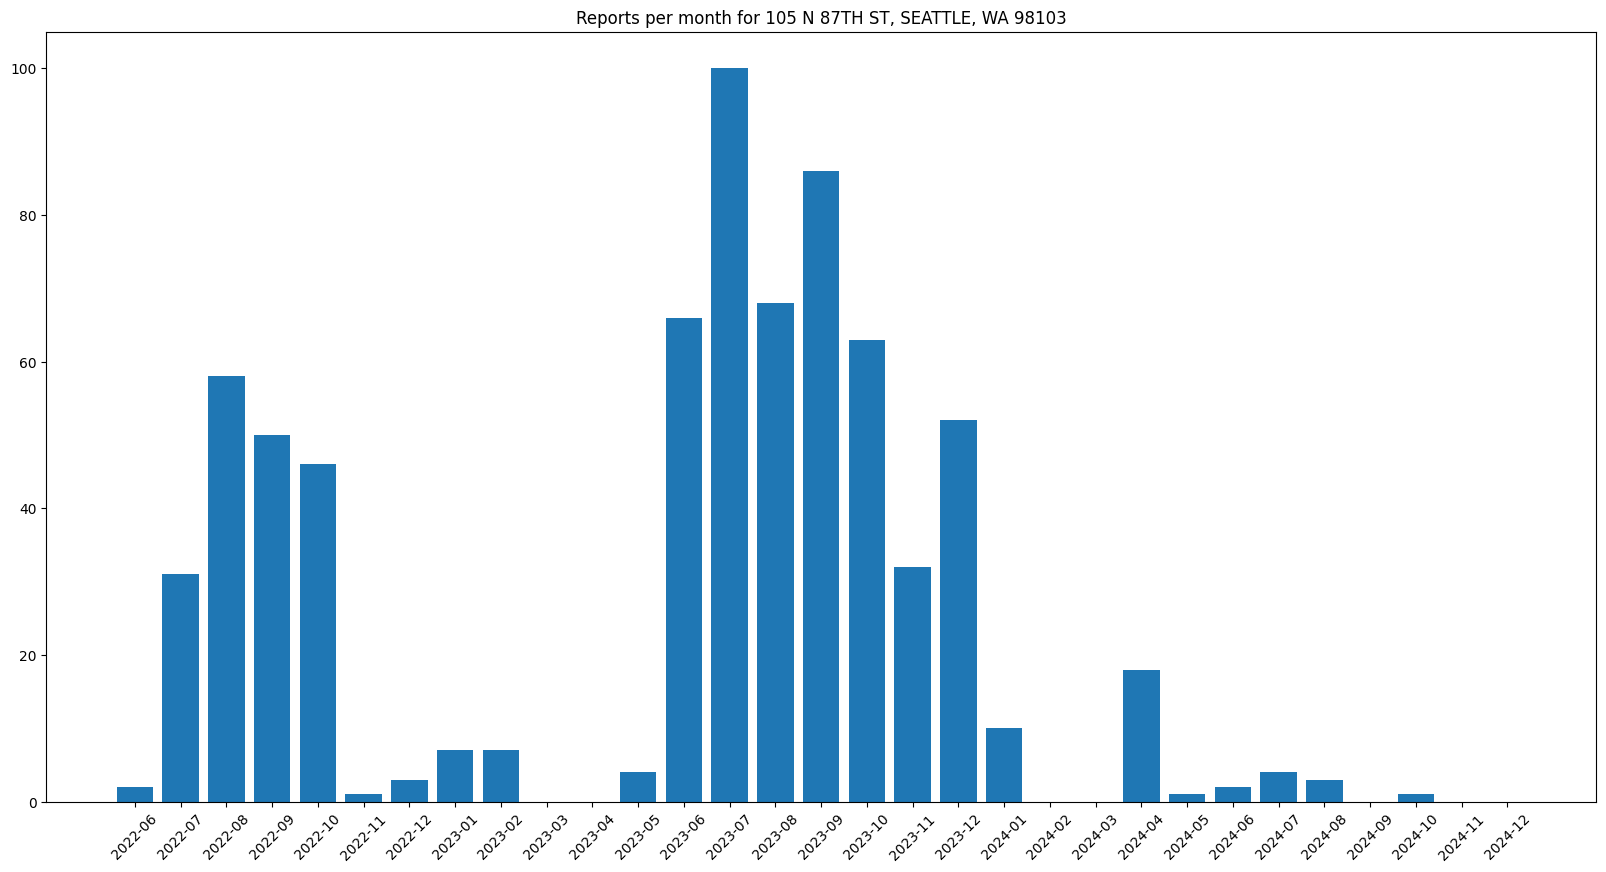

Map(center=[47.69226502, -122.35769596], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_t…

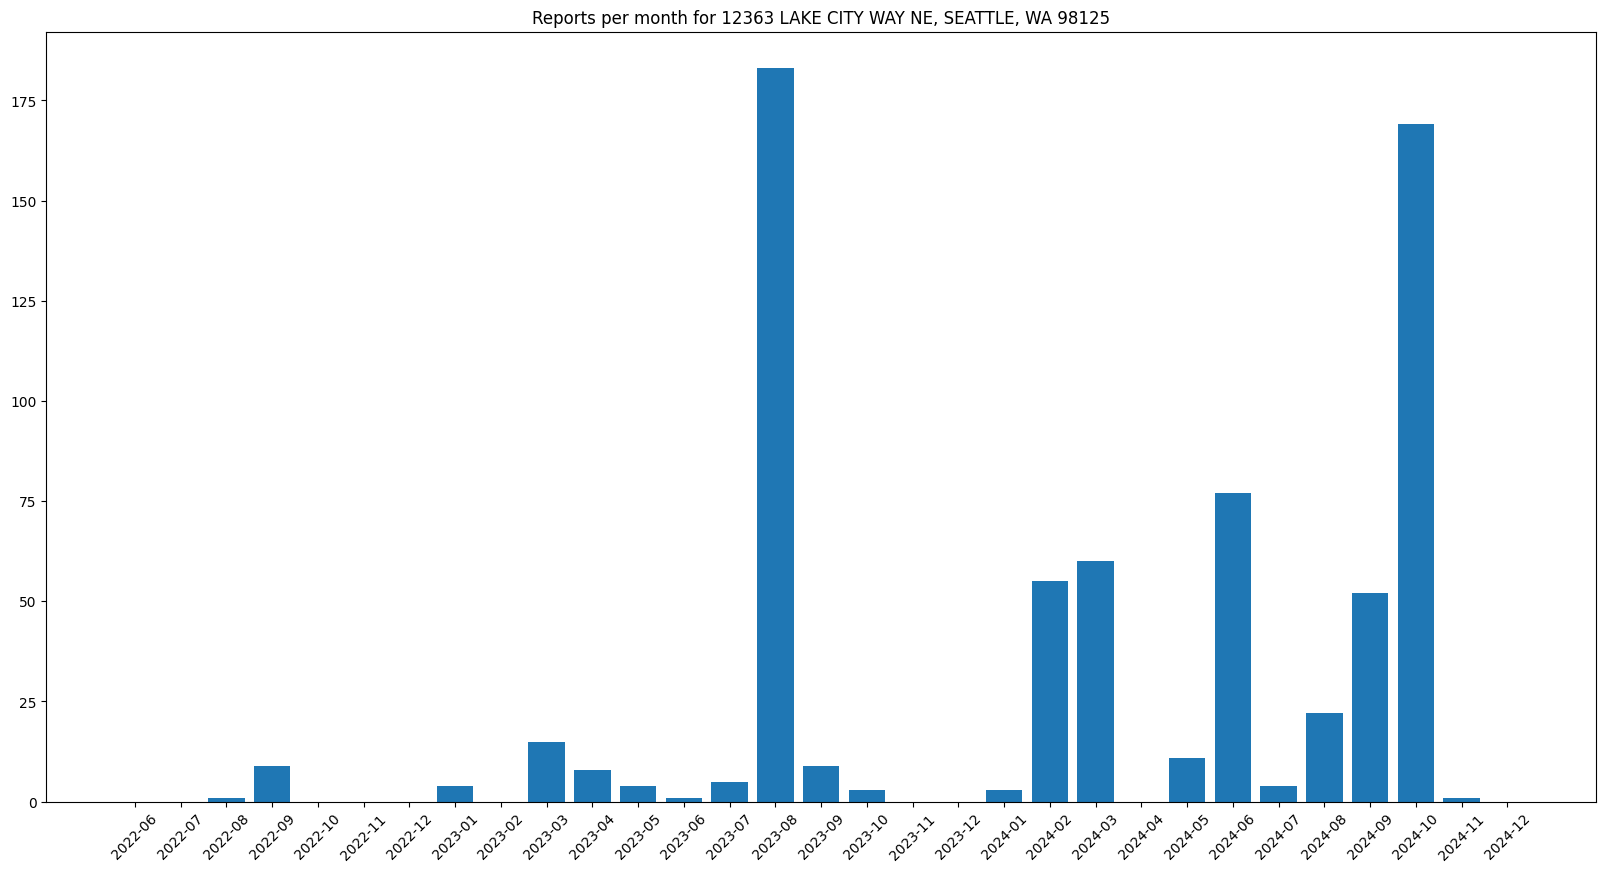

Map(center=[47.71910747, -122.29588427], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_t…

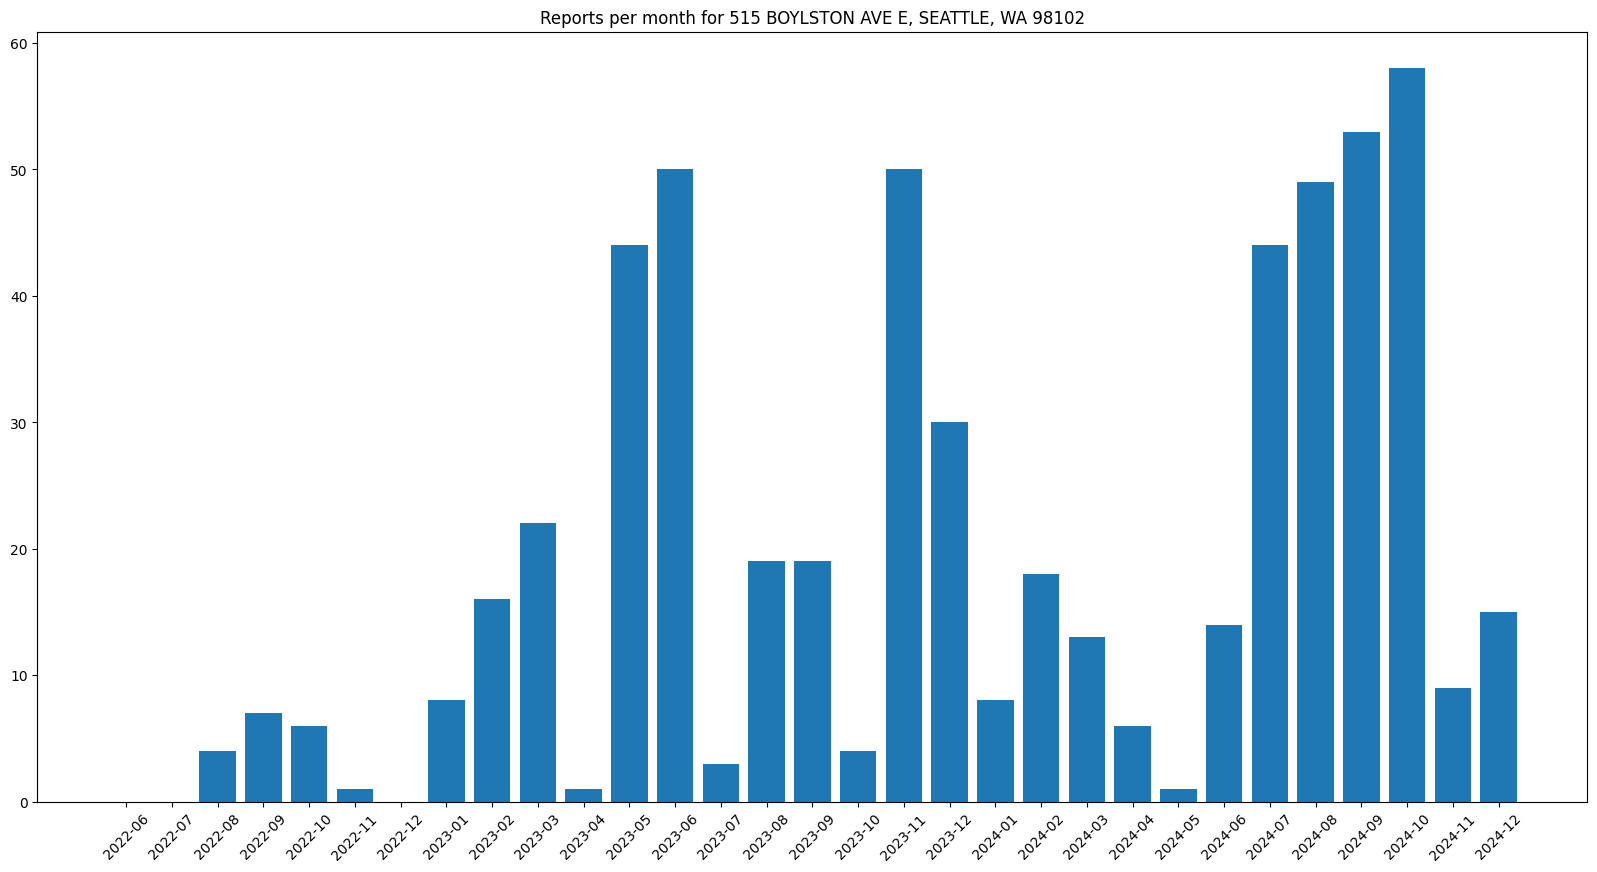

Map(center=[47.62388873, -122.32333517], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_t…

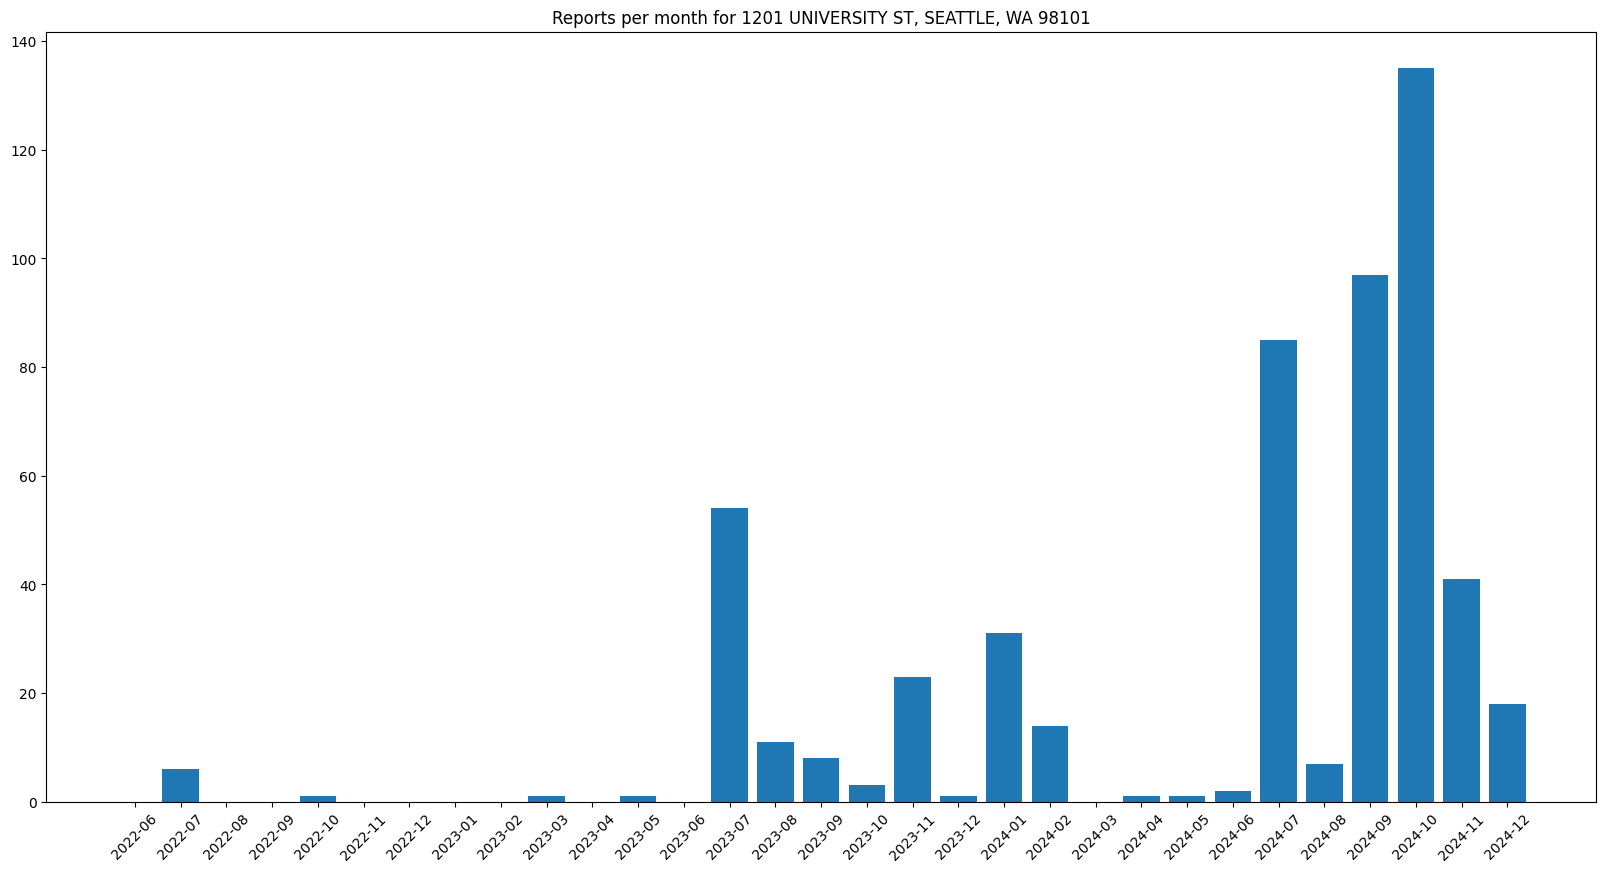

Map(center=[47.61194995, -122.32549491], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_t…

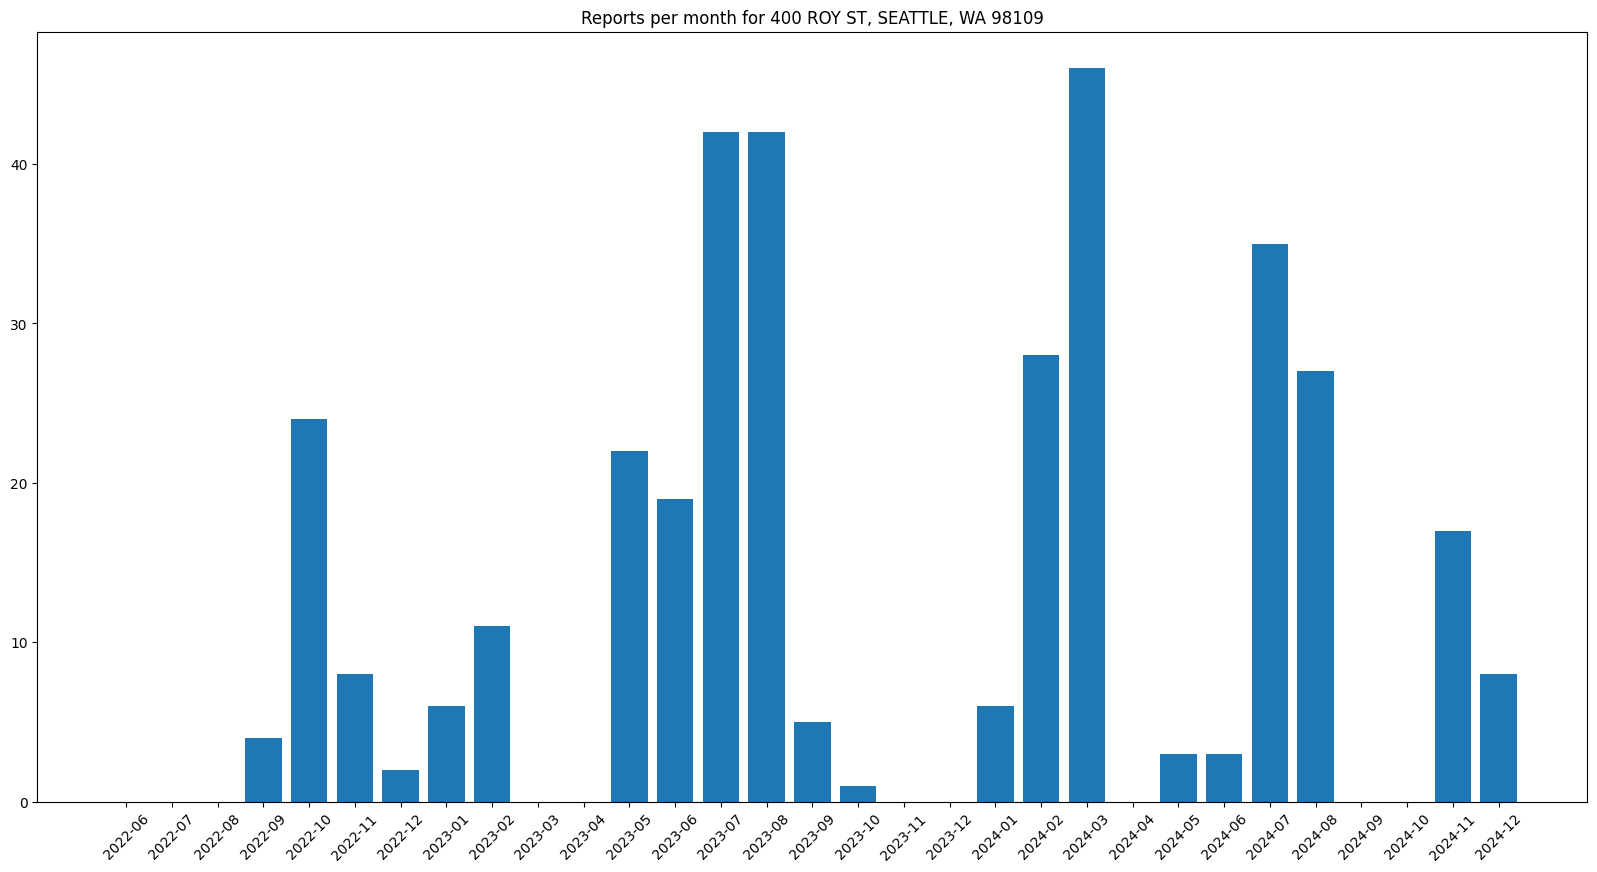

Map(center=[47.62560217, -122.34865199], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_t…

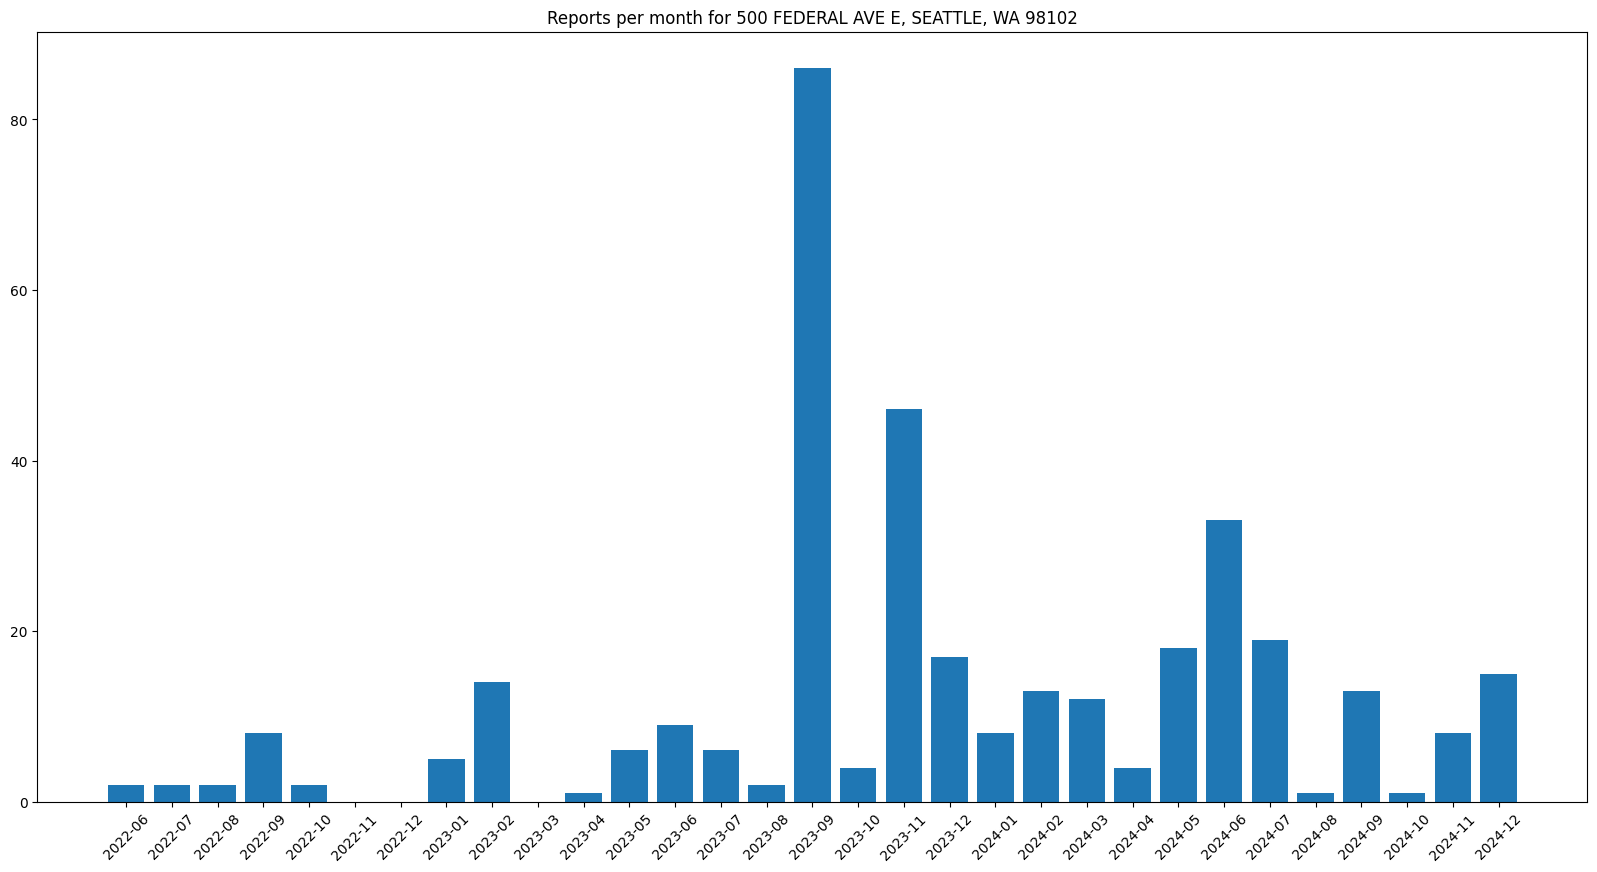

Map(center=[47.6232882, -122.31861375], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_ti…

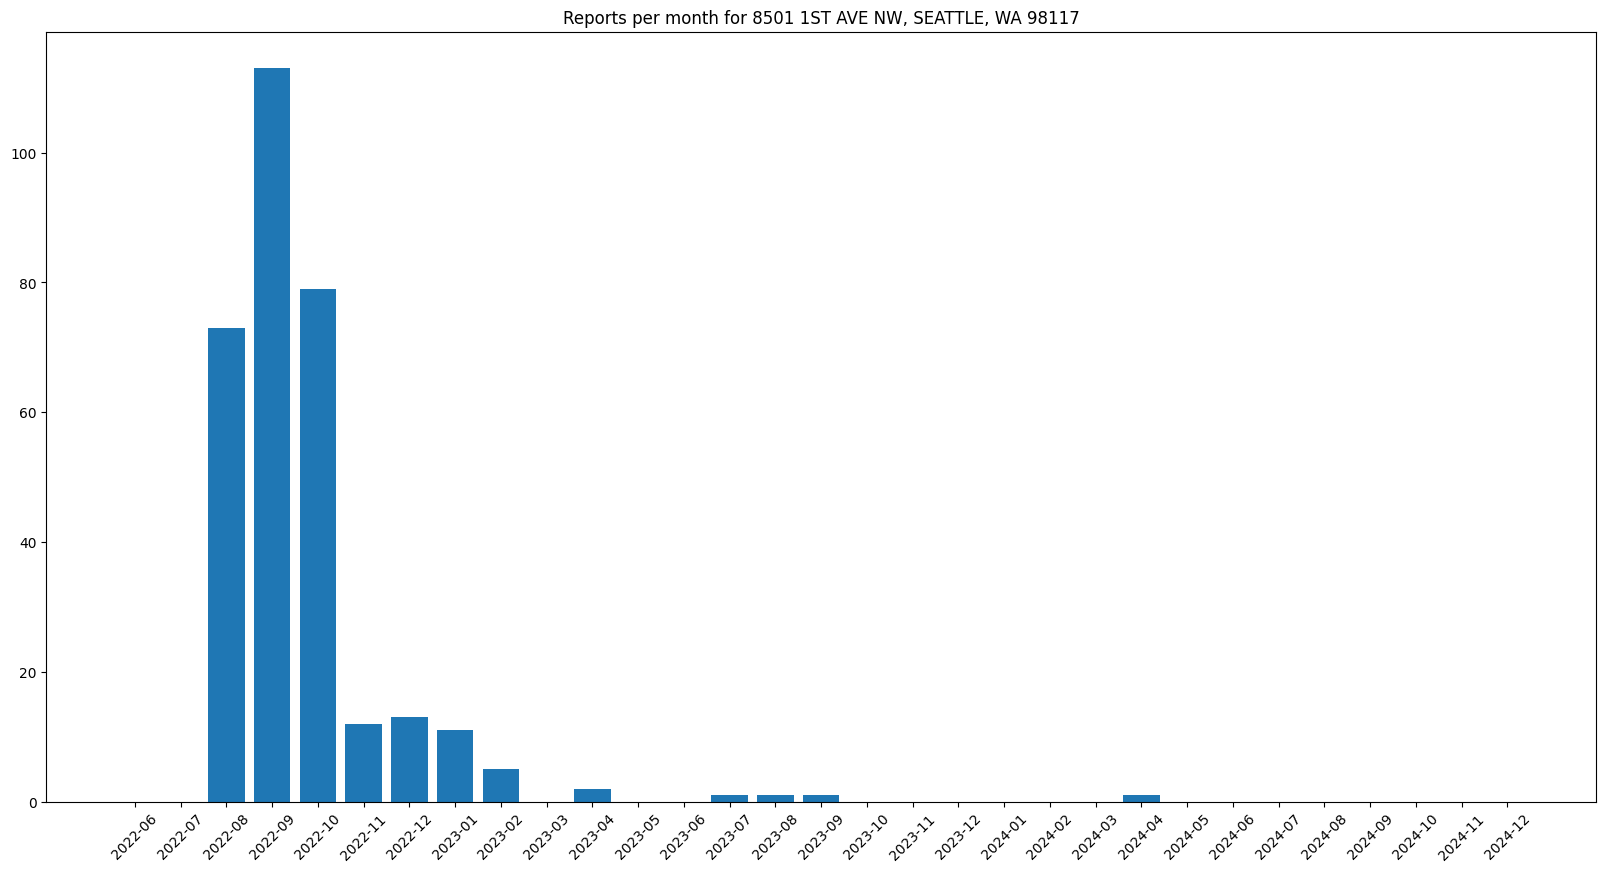

Map(center=[47.69084508, -122.35832403], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_t…

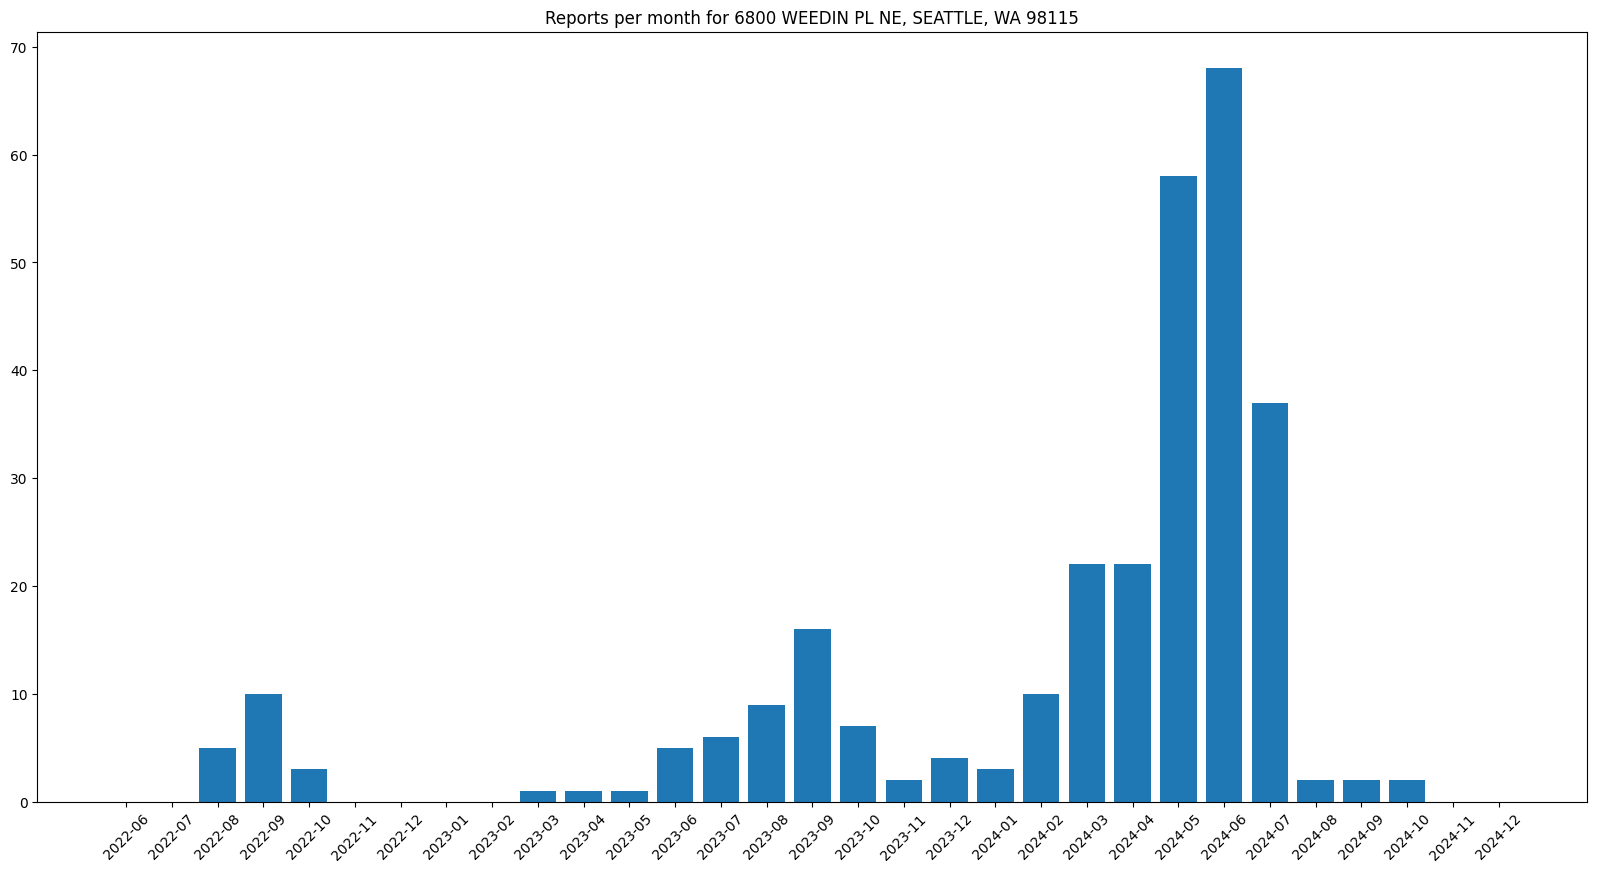

Map(center=[47.67856857, -122.32161751], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_t…

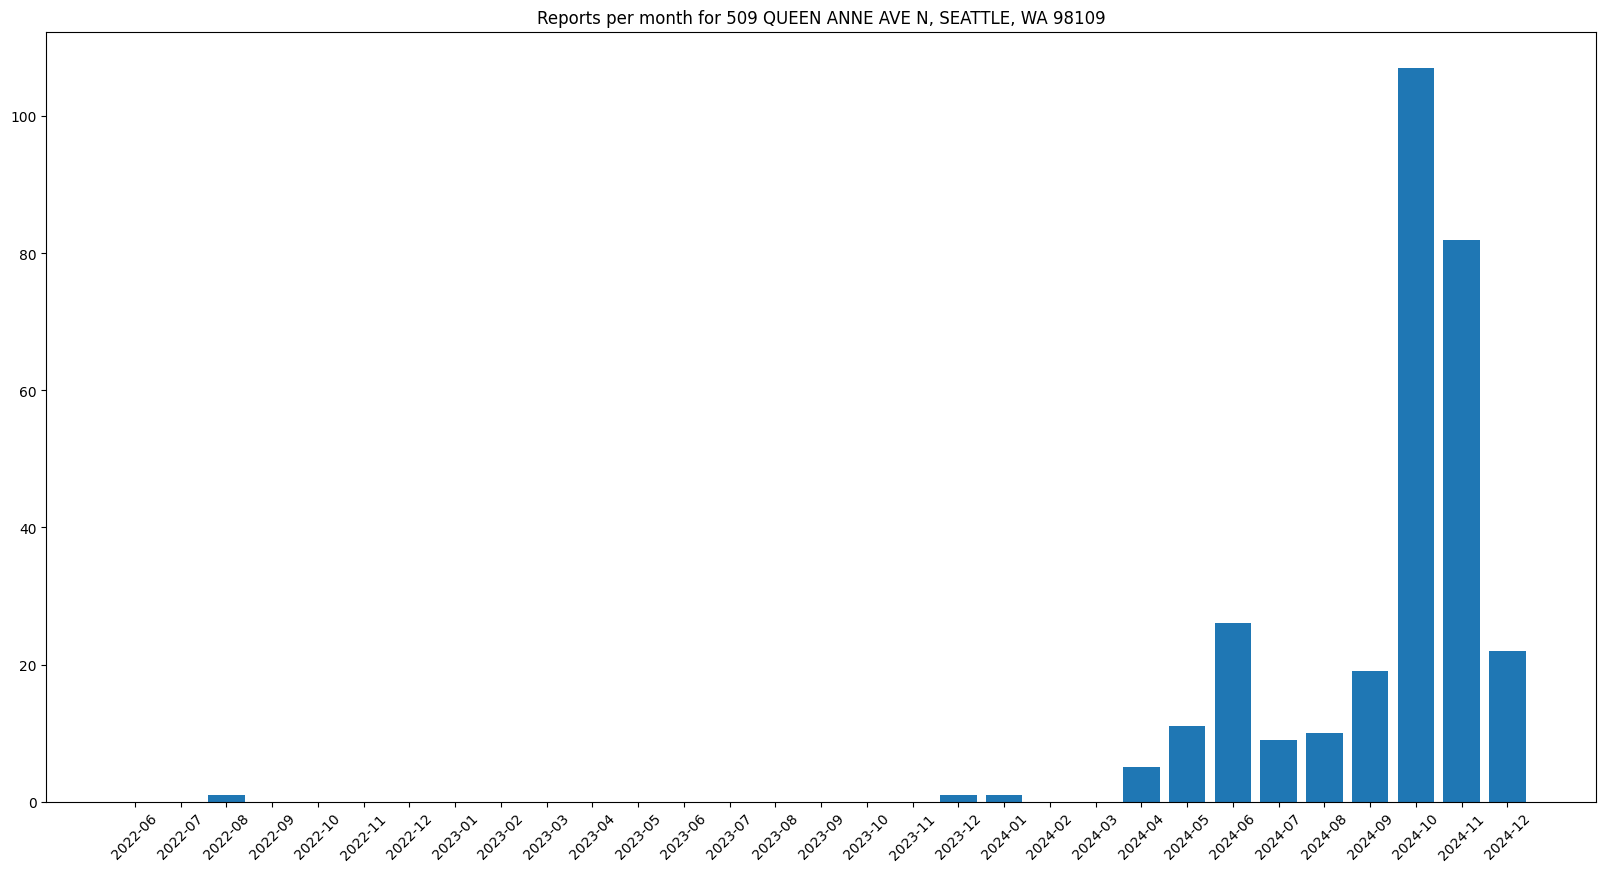

Map(center=[47.62353179, -122.35709753], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_t…

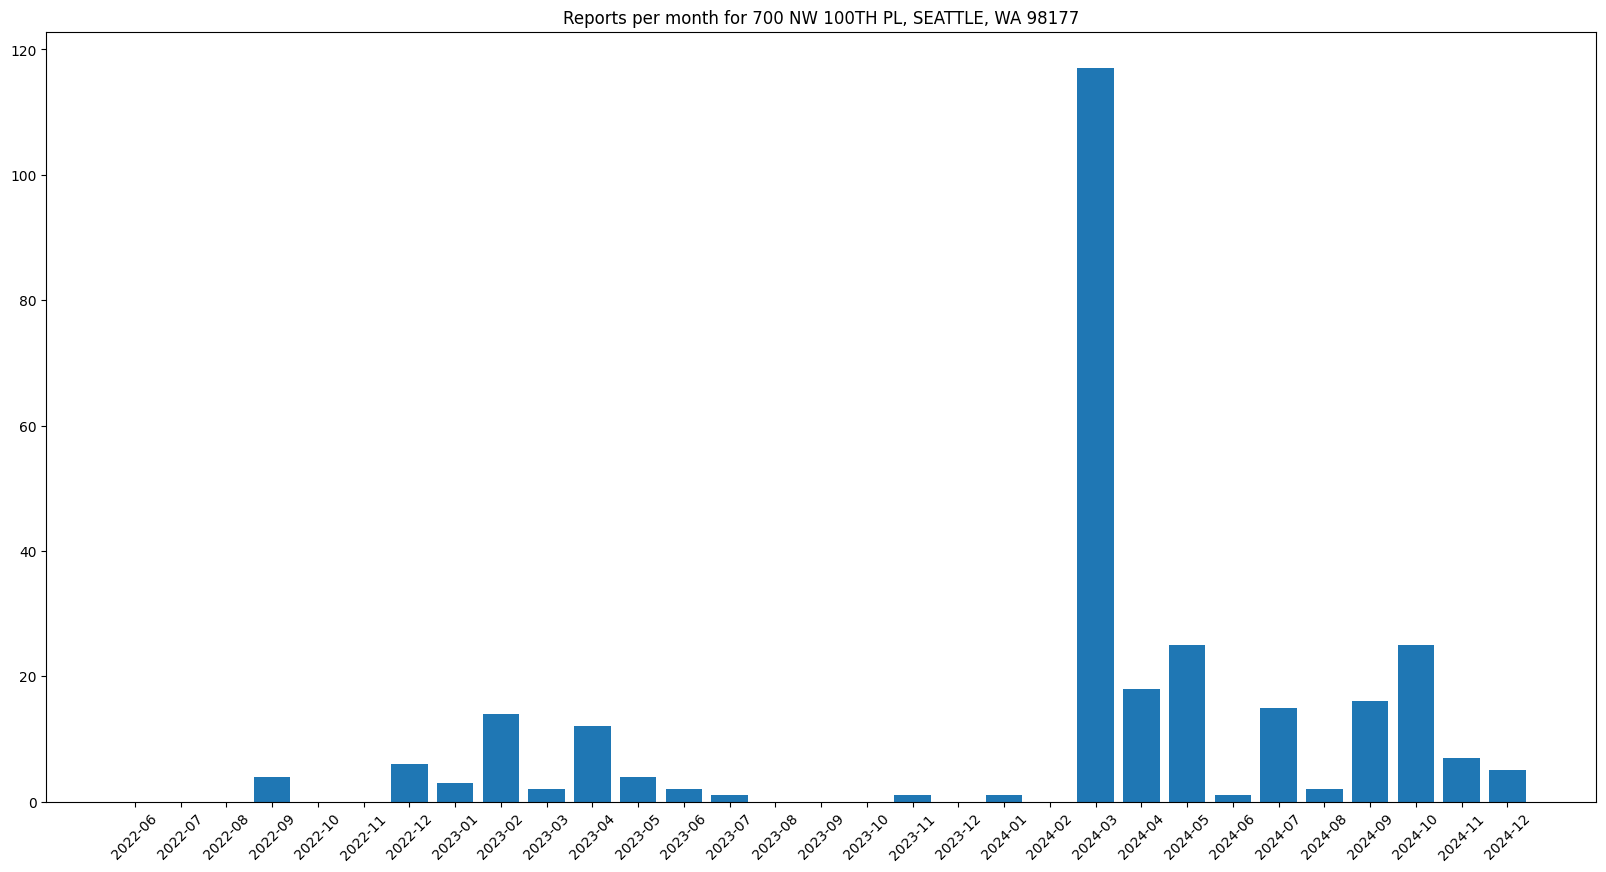

Map(center=[47.70171051, -122.36504218], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_t…

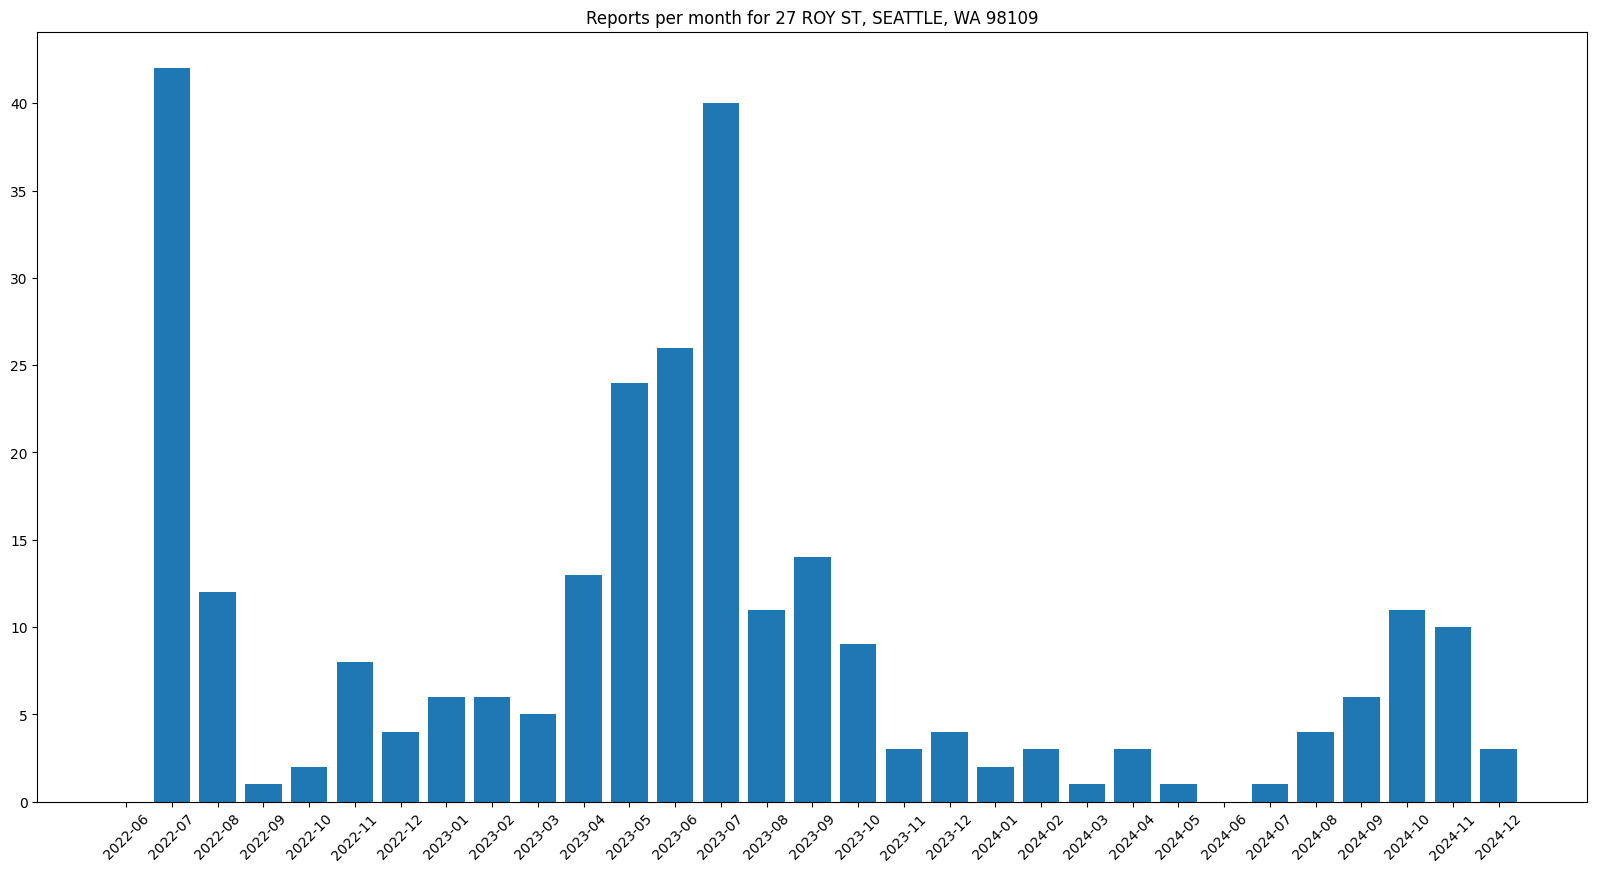

Map(center=[47.62528352, -122.3556621], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_ti…

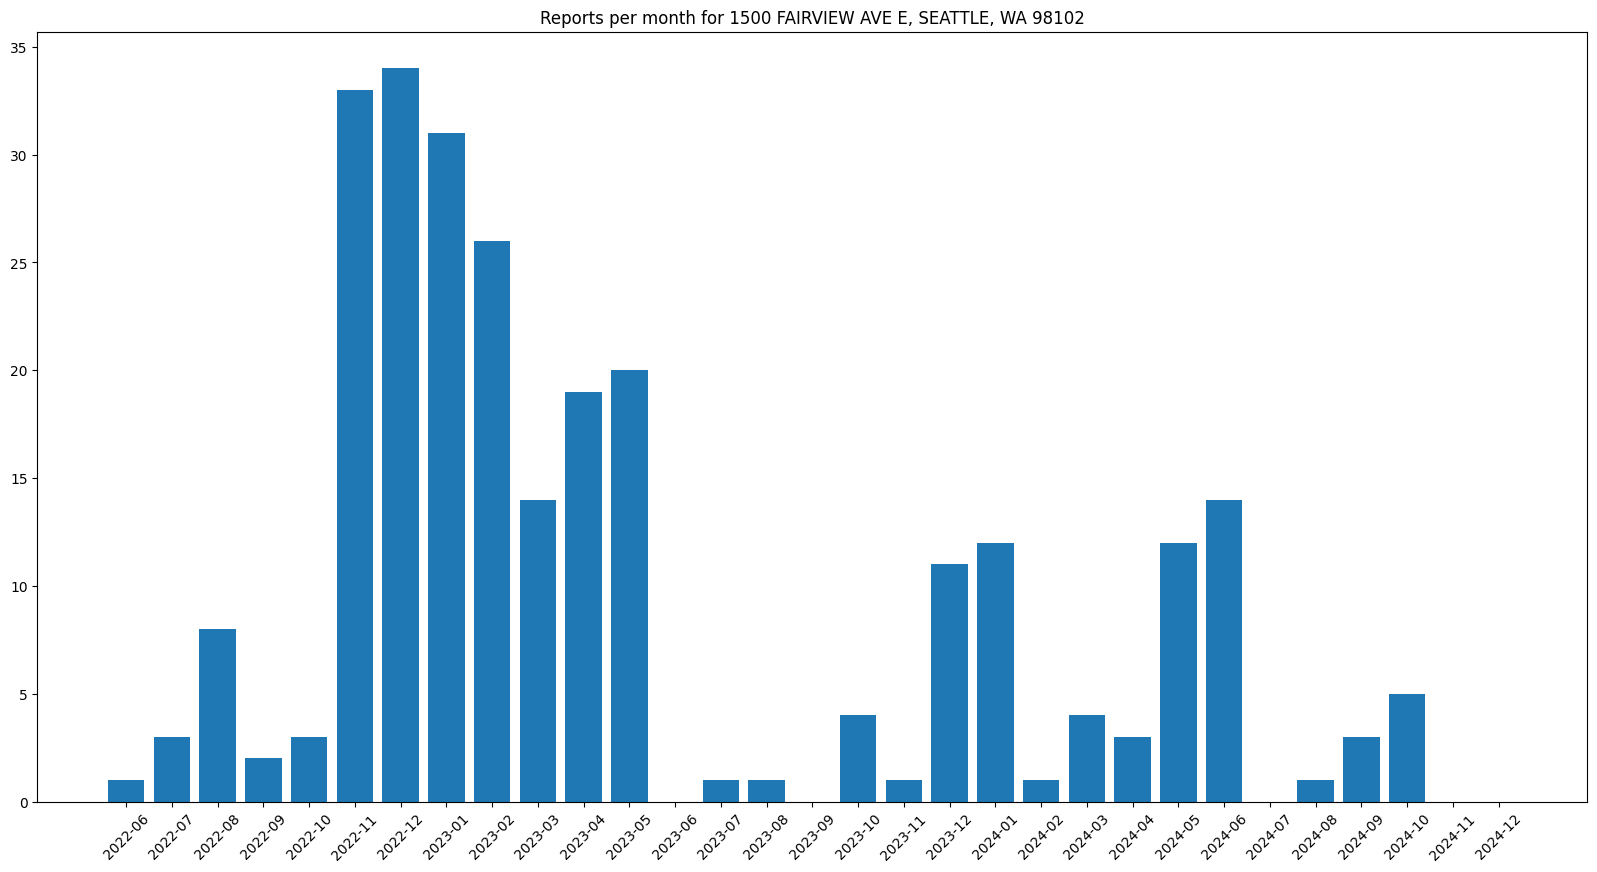

Map(center=[47.6324583, -122.32657841], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_ti…

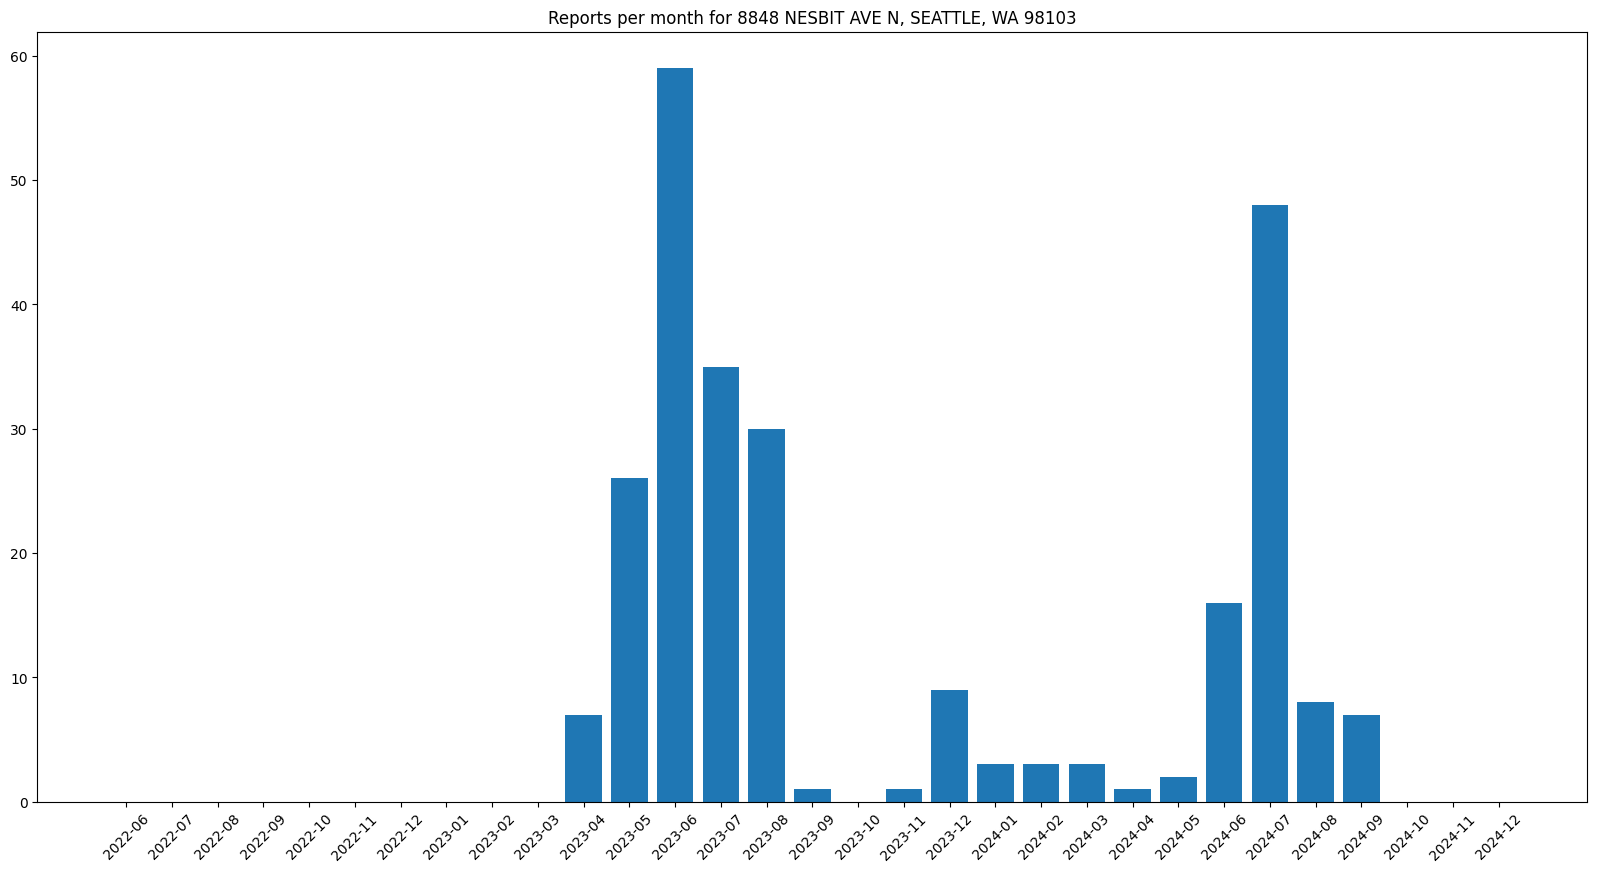

Map(center=[47.69386336, -122.34323799], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_t…

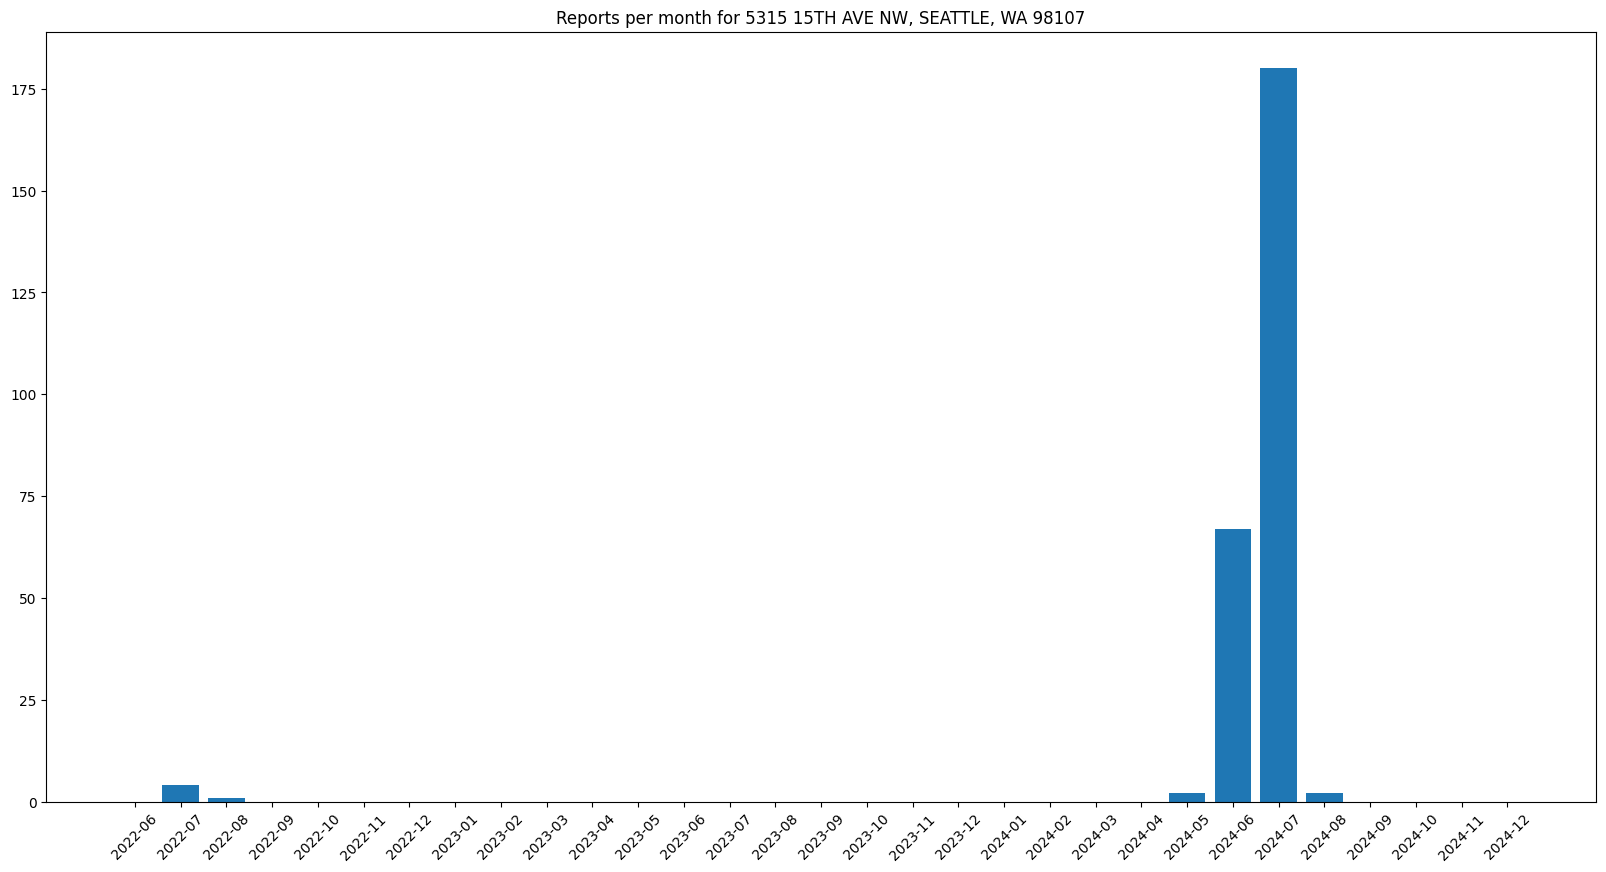

Map(center=[47.66775055, -122.37682384], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_t…

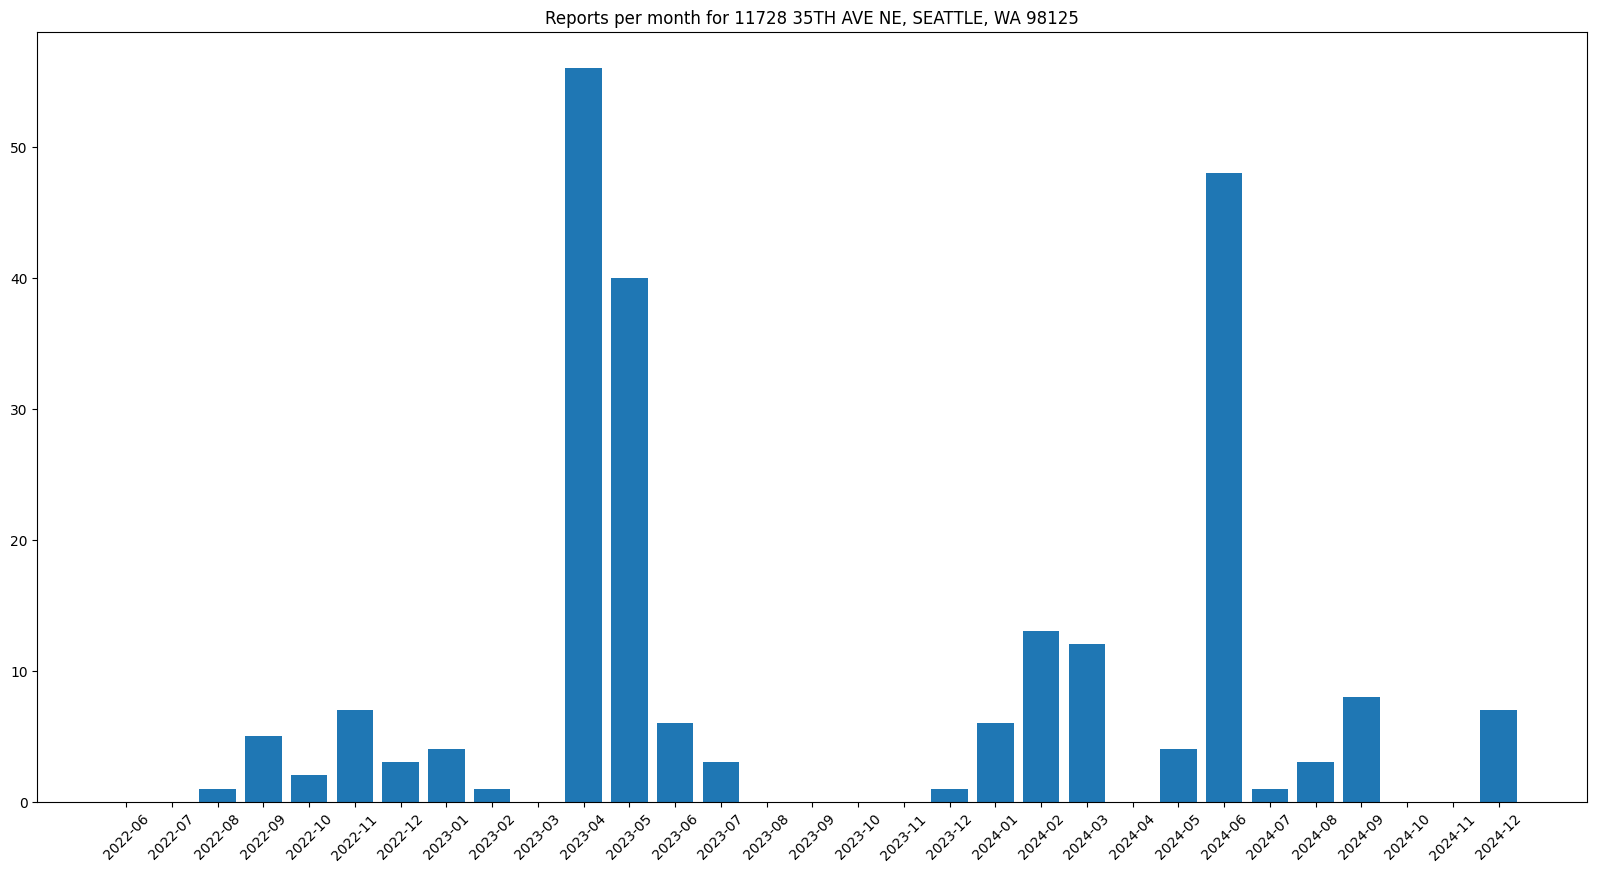

Map(center=[47.71459275, -122.29129904], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_t…

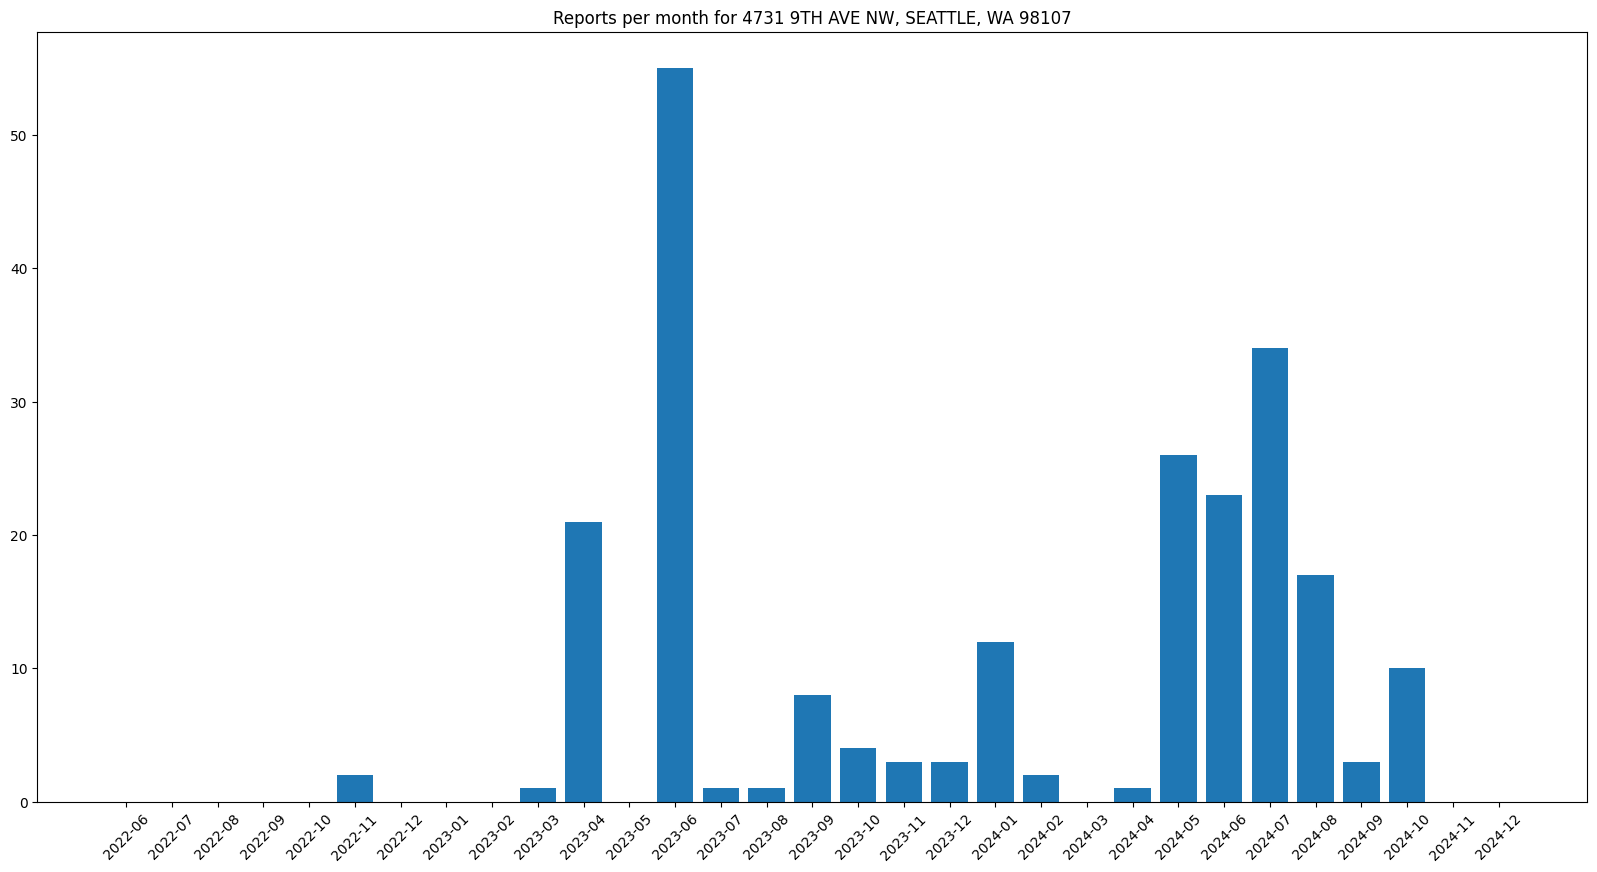

Map(center=[47.66349296, -122.36883703], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_t…

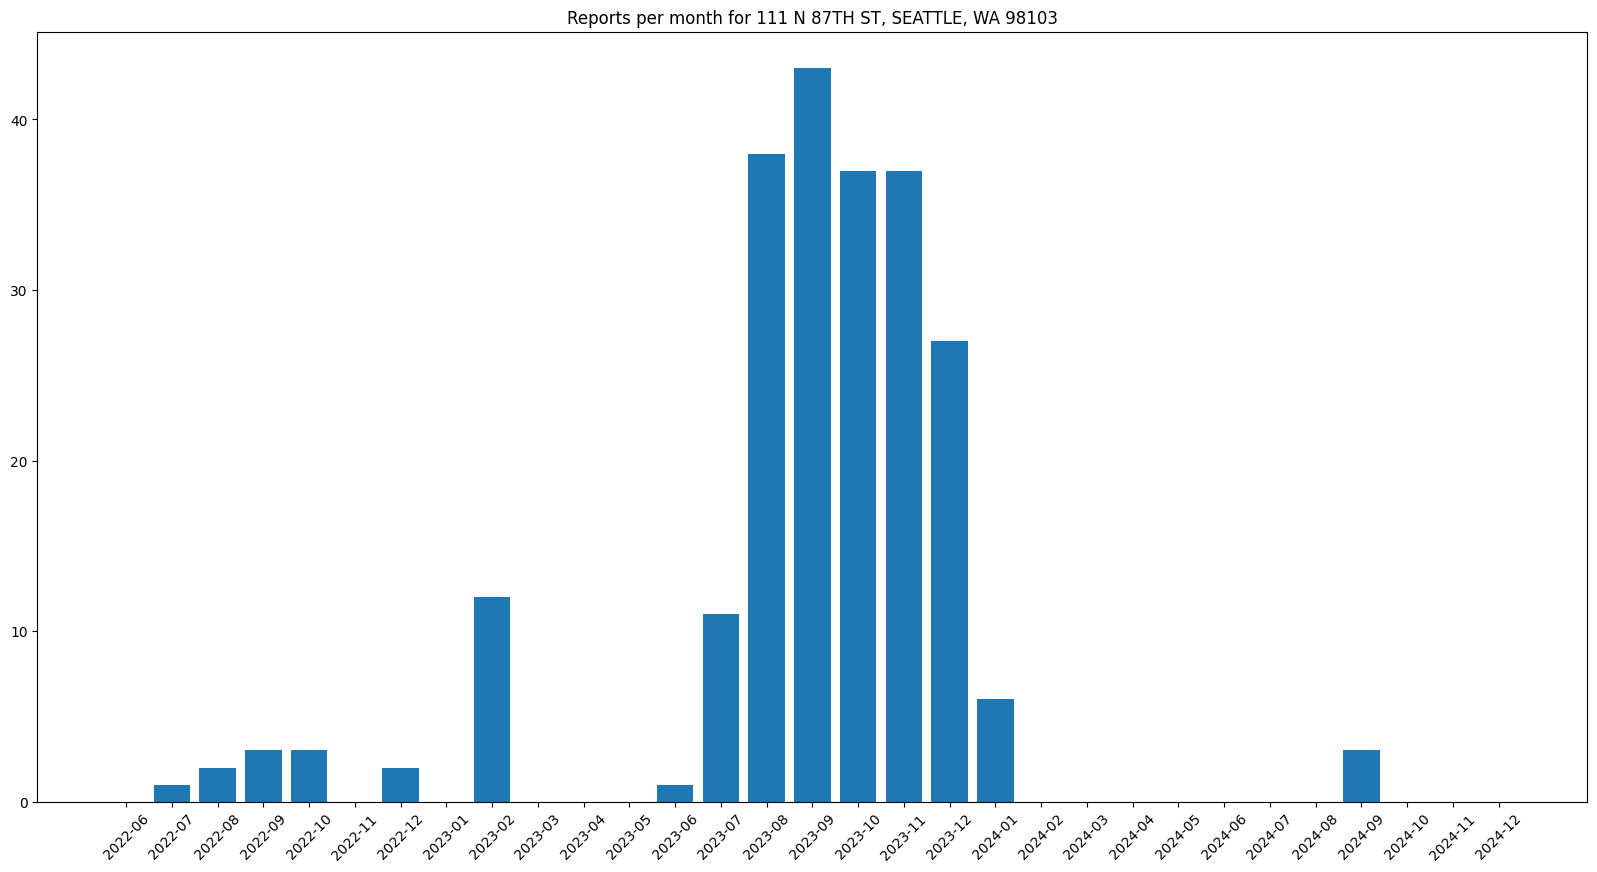

Map(center=[47.6925109, -122.35736886], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_ti…

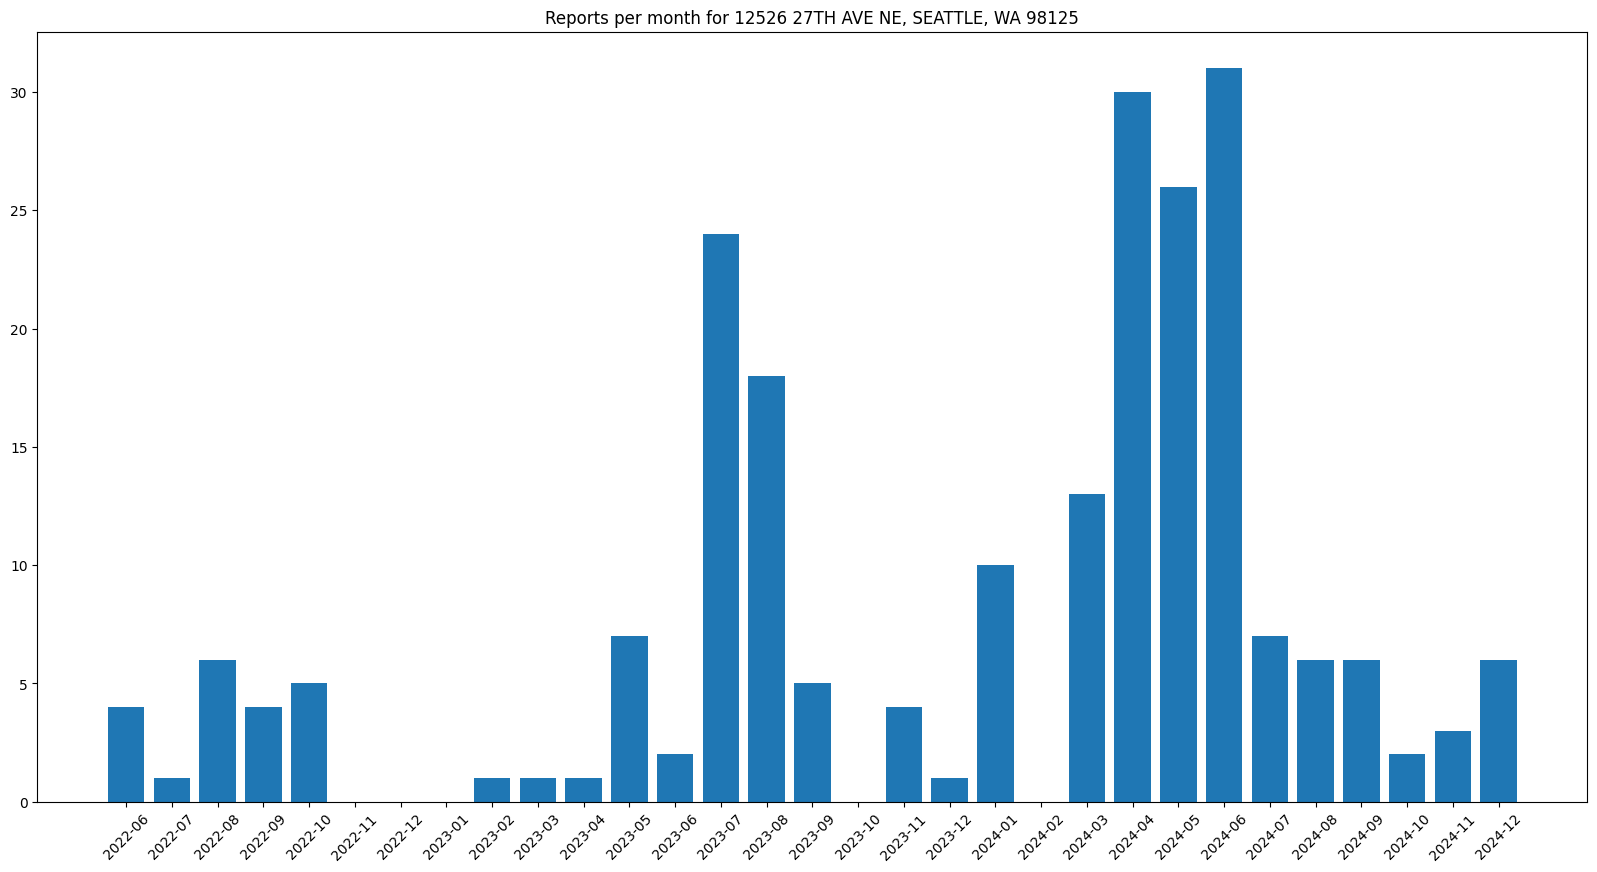

Map(center=[47.72005699, -122.29867947], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_t…

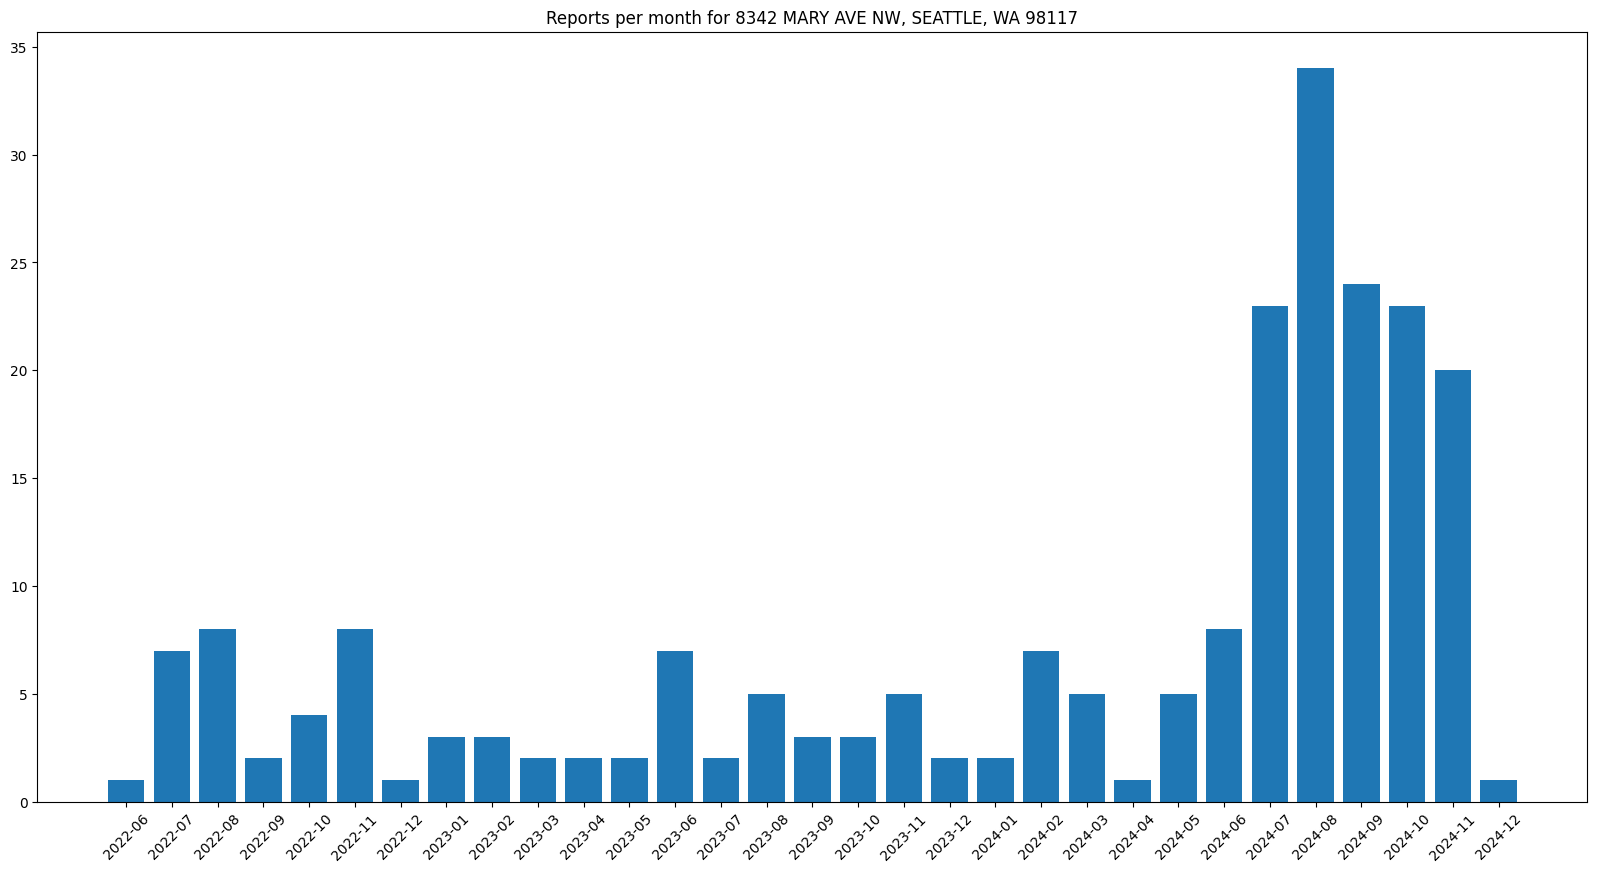

Map(center=[47.68994468, -122.3752917], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_ti…

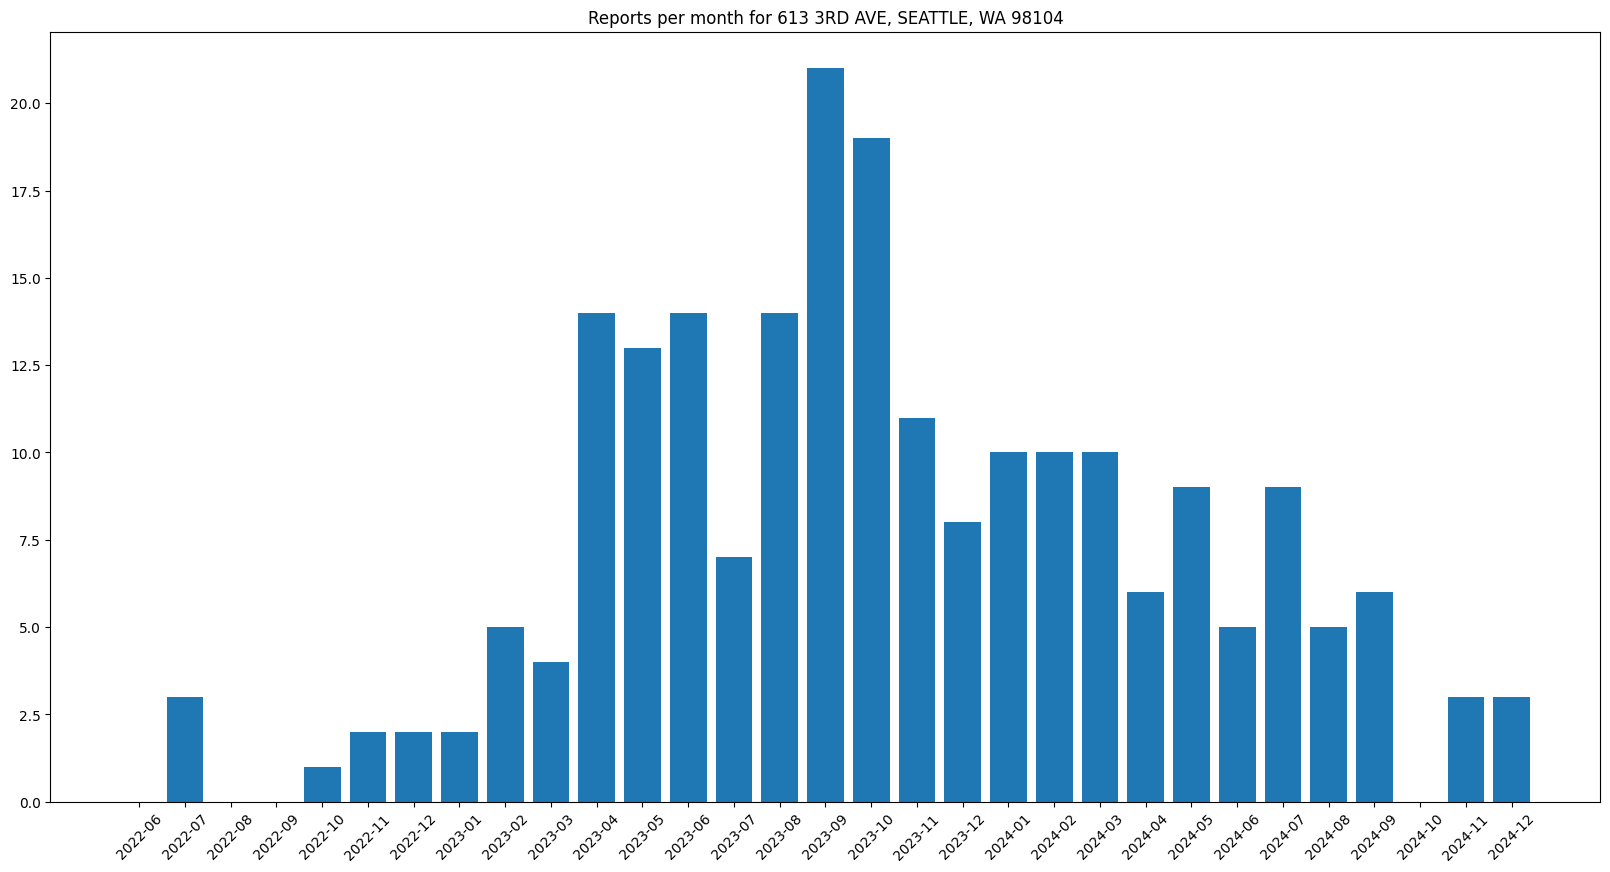

Map(center=[47.60318067, -122.33206196], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_t…

In [39]:
import datetime
from collections import Counter

# Grab the top `limit` locations with the most reports all-time
limit = 20
result = conn.execute(f"SELECT Location, Latitude, Longitude, COUNT(*) as ReportCount FROM read_csv('{file_path}') GROUP BY Location, Latitude, Longitude ORDER BY COUNT(*) DESC LIMIT {limit}")

# For each one, create a histogram by calendar month, 
# starting with 06/2022 and ending with 12/2024
# Each month will contain the number of reports for that location in that month
histograms: dict[tuple[str, float, float], dict[str, int]] = {}
for row in result.fetchdf().itertuples():
	location = t.cast(str, row.Location)
	lat = t.cast(float, row.Latitude)
	lon = t.cast(float, row.Longitude)
	# Query duckdb for all reports at this location across all time
	location_result = conn.execute(f"SELECT \"Created Date\" as CreatedDate FROM read_csv('{file_path}') WHERE Location = '{location}'")
	# For each location_result, generate a list that contains only "MM/YYYY" strings
	mm_yyyys = []
	for location_row in location_result.fetchdf().itertuples():
		created_date = t.cast(datetime.datetime, location_row.CreatedDate)
		mm_yyyy = f"{created_date.year:04d}-{created_date.month:02d}"
		mm_yyyys.append(mm_yyyy)
	# Store the histogram in the dictionary
	counter = Counter(mm_yyyys)
	# Create a dictionary for all months from 6/2022 to 12/2024
	ordered_counts: dict[str, int] = {}
	for year in range(2022, 2025):
		for month in range(1, 13):
			if year == 2022 and month < 6:
				continue
			if year == 2024 and month > 12:
				continue
			ordered_counts[f"{year:04d}-{month:02d}"] = 0
	# Fill in the counts from the counter, where available
	for k, v in counter.items():
		ordered_counts[k] = v
	histograms[(location, lat, lon)] = ordered_counts
	
# Plot the first location's histogram
import matplotlib.pyplot as plt  # noqa
import numpy as np  # noqa

for lll, data in histograms.items():
	location, lat, lon = lll
	months = list(data.keys())
	values = list(data.values())
	plt.figure(figsize=(20, 10))
	plt.bar(np.arange(len(months)), values)
	plt.xticks(np.arange(len(months)), months, rotation=45)
	# # Place a smoothing curve over the histogram
	# smoothed = np.convolve(values, np.ones(5)/5, mode='valid')
	# plt.plot(np.arange(len(smoothed)), smoothed, color='green')
	plt.title(f"Reports per month for {location}")
	plt.show()

	# Create a tiny map centered on the location, with a single 25px marker
	# zoom level 14
	m = ipyleaflet.Map(center=(lat, lon), zoom=14)
	marker = ipyleaflet.CircleMarker(location=(lat, lon), title=location, radius=25)
	m.add_layer(marker)
	display(m)